# Лабораторная работа №1.1 "Экспериментальная проверка уравнения Эйнштейна для фотоэффекта и определение постоянной Планка"

В работе исследуется зависимость фототока от величины задерживающего потенциала и частоты падающего излучения, что позволяет вычислить величину постоянной Планка.

Уравнение Эйнштейна:
\begin{equation}
\label{eq1}
\hbar \omega = E_{\text{max}} + W
\end{equation}
где $E_{\text{max}}$ - максимальная кинетическая энергия электрона после выхода из фотокатода, $W$ - работа выхода электрона из катода.

Из описания имеем формулу для полного числа частиц:
\begin{equation}
\label{eq2}
N(\nu) = 2\pi n_0 \left[ \dfrac{\nu_0^2}{4} - \left(\dfrac{1 - V/V_0}{\nu_0} - \dfrac{\nu_0}{2}\right)^2 \right]
\end{equation}
Корень квадратный из фототока линейно зависит от запирающего напряжения.

### Калибровочный график

In [311]:
import pandas as pd

CALIBRATION_DATA_PATH = './calibration.csv'
LAMP_DATA_PATH = './all_data.csv'
df_calibration = pd.read_csv(CALIBRATION_DATA_PATH, sep=';', dtype=float)

# Длина волны дана в ангстремах. Переведем ее в нм:
df_calibration['lambda'] /= 10

df_calibration.head()

,lambda,angle
0,534.1,1830.0
1,540.1,1878.0
2,585.2,2140.0
3,588.2,2150.0
4,594.5,2180.0


Посмотрим, является ли калибровочный график прямой

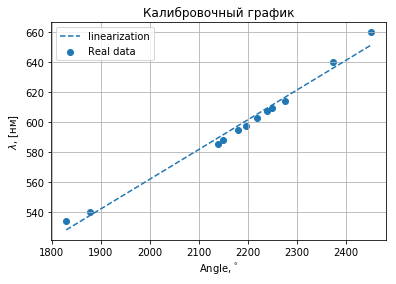

In [312]:
import matplotlib.pyplot as plt

y, x = df_calibration['lambda'], df_calibration['angle']
plt.scatter(x, y, label='Real data')

# Аппроксимация
from scipy.stats import linregress
calibration_slope, calibration_intercept, r_value, p_value, std_err = linregress(x,y)
plt.plot(x, calibration_slope*x+calibration_intercept, '--', label='linearization')

plt.ylabel('$\lambda$, [нм]')
plt.xlabel('Angle, $^\degree$')
plt.grid()
plt.legend()
plt.title(r'Калибровочный график')

plt.show()

Видно, что в середине диапазона калибровочной график хорошо описывается прямой. Это нам пригодится в будущем, а пока сделаем функцию для перевода угла в длину волны

In [313]:
angle_to_lambda = lambda angle: calibration_slope*angle + calibration_intercept

### Информация с лампы

In [314]:
df_lamp = pd.read_csv(LAMP_DATA_PATH, sep=';', dtype=float)
df_lamp.head()

,angle,V,I
0,1850.0,5.440,0.517
1,1850.0,4.910,0.508
2,1850.0,4.412,0.501
3,1850.0,3.915,0.491
4,1850.0,3.409,0.478


In [315]:
# Добавим погрешности
df_lamp['I_error'] = 0.01

In [316]:
angles = pd.unique(df_lamp['angle'])

На самом деле, в столбце $I$ находится не сам $I$, а напряжение, пропорциональное $I$. Но для нас это не важно, так как в этой работе мы интересуемся только напряжением запирания. **Поэтому будем дальше писать $I$ вместо $U$.**

Из уравнения выше следует, что нам надо строить график зависимости $V = V(\sqrt{I})$.

#### Угол $1850˚$

In [317]:
# НЕ НУЖНО. Дает плохую аппроксимацию, поэтому
# мы просто аппроксимируем прямой ближе к концу
from sklearn.base import BaseEstimator
class SigmoidRegressor(BaseEstimator):
    
    def __init__(self, function):
        self.func = function
        
    def fit(self, x_data, y_data):
        scX, scY = StandardScaler(), StandardScaler()
        x_fit = scX.fit_transform(np.array(x_data).reshape(-1, 1)).reshape(1, -1)[0]
        y_fit = scY.fit_transform(np.array(y_data).reshape(-1, 1)).reshape(1, -1)[0]
        from scipy.optimize import curve_fit
        popt, pcov = curve_fit(func, x_fit, y_fit)
        opt_func = lambda x: scY.inverse_transform(func(
            scX.transform(np.array(x).reshape(-1, 1)), 
            *popt)).reshape(1, -1)[0]
        self.scX, self.scY, self.opt_func = scX, scY, opt_func
        return self
        
    def predict(self, x_data):
        return self.opt_func(x_data)

In [352]:
def fit_line_at_range(x_data, y_data, limits=None):
    """
    Подгоняет прямой на заданном интервале
    """
    if limits is None:
        limits = np.min(x_data), np.max(x_data)
    x_data = x_data.copy()
    y_data = y_data.copy()
    x_range = (x_data >= limits[0]) & (x_data <= limits[1])
    x_data, y_data = x_data[x_range], y_data[x_range]
    return linregress(x_data, y_data)

In [353]:
def handle_angle(angle, limits, fig=None, axes=None):
    """
    Обработка конкретного угла
    """
    import numpy as np
    import scipy as sc
    
    if fig is None or axes is None:
        fig, axes = plt.subplots(figsize=(16, 9))

    # Отберем нужный угол из глобального датасета
    subset = df_lamp[df_lamp['angle'] == angle]

    # Подсчитаем квадрат (как в лабнике)
    y, x = subset['I']**2, subset['V']
    # Нанесем экспериментальные точки
    axes.scatter(x, y, label='experiment')
    
    x_spline = np.linspace(np.min(x), np.max(x), 1000)
    
    slope, intercept, r_value, p_value, std_error = fit_line_at_range(x, y, limits)
    print(slope)
    fit_function = lambda x: slope*x+intercept
    axes.plot(x_spline, fit_function(x_spline), '--', label=r'Лин.регрессия')
    
    
    # Попытаемся приблизить сигмоидой
    #funcs = [
    #    lambda x, k, a, b: k/(1+np.exp(-a*x + b)),
    #    lambda x, k, a, b: k*np.tanh(x - a),
    #    lambda x, k, a, b: k*np.arctan(x - a),
    #    lambda x, k, a, b: k*np.acos(x - a)
    #]
    #sigmoid_regressor = SigmoidRegressor(funcs[1])
    #y_spline = sigmoid_regressor.fit(x, y).predict(x_spline)
    #axes.plot(x_spline, y_spline, '--', label=r'Сплайны')

    axes.set_ylabel(r'$\sqrt{I}$')
    axes.set_xlabel(r'$V$')
    axes.grid()
    axes.legend()
    
    fig.savefig('angle-%s.pdf' % angle)
    
    return fig, axes

0.19294230769230772
0.09364575084263227
0.023837827121332273


(<Figure size 1152x648 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x11a89a780>)

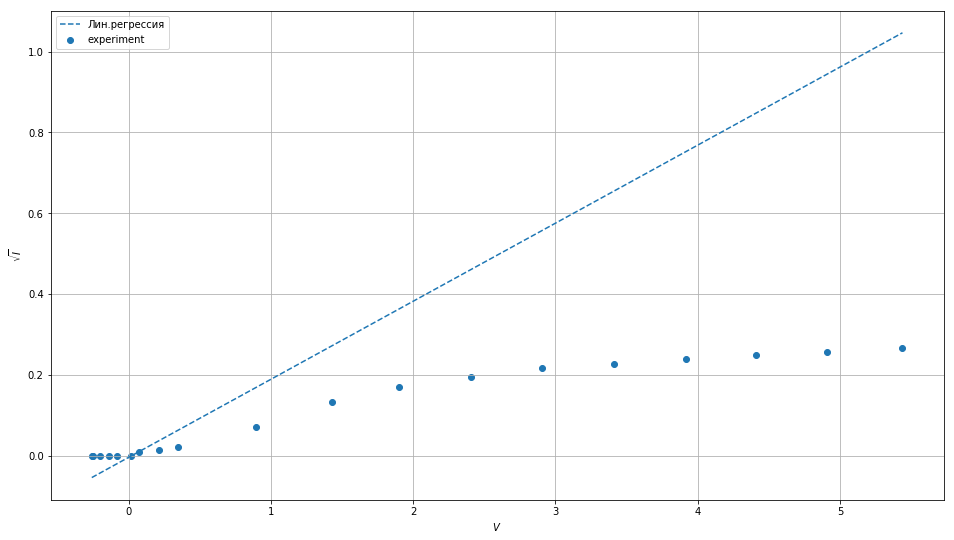

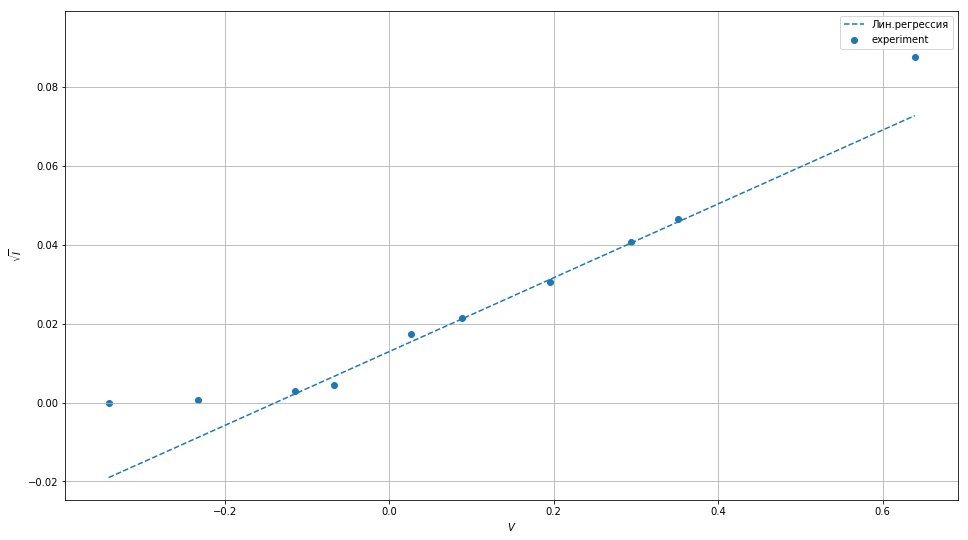

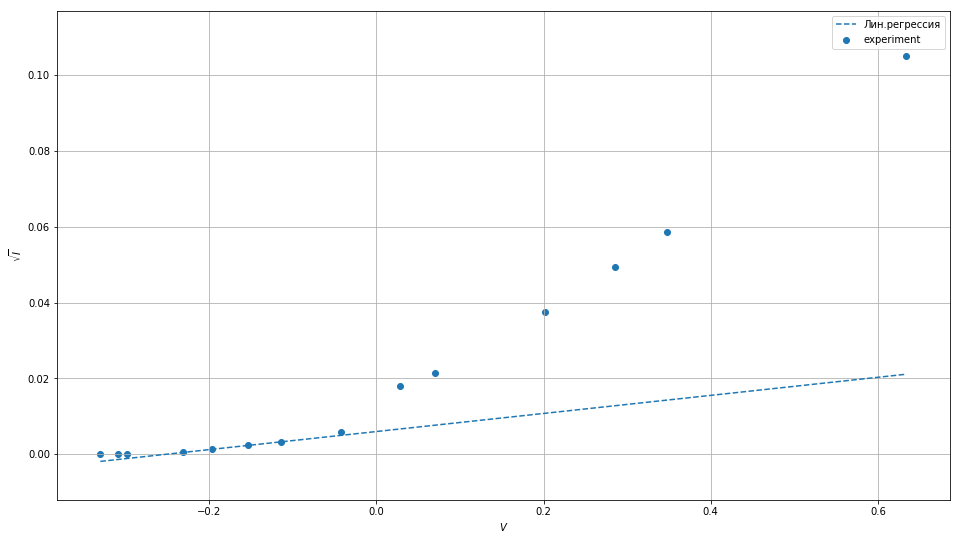

In [354]:
#fig, axes = plt.subplots(figsize=(16, 9))
# График 1
handle_angle(angles[0], (-0.05, 0.1))
# 2
handle_angle(angles[1], (-0.17, 0.2))
# 3
handle_angle(angles[2], (-0.2, -0.1))

Дальнейшие результаты опираются на экстраполяцию. Мы будем **полагать**, что она выполнена успешно и _заданы_ напряжения запирания

In [275]:
V_0 = [-0.1, -0.2, -0.22, -0.24, -0.15]

Эти значения запирающих напряжений соответствуют каким-то $\lambda_i$. Найдем их, исходя из знаний соответствующих углов и калибровочного графика:

In [276]:
df_V_lambda = pd.DataFrame(columns=['lambda', 'V_0'])

In [277]:
df_V_lambda['lambda'] = [calibration_slope*angle + calibration_intercept for angle in angles]
df_V_lambda['V_0'] = V_0

In [280]:
df_V_lambda['omega'] = 2*np.pi*3*10**9/(df_V_lambda['lambda']*10**(-9))

In [281]:
df_V_lambda

,lambda,V_0,omega
0,532.020868,-0.10,3.543011e+16
1,553.823492,-0.20,3.403531e+16
2,575.626115,-0.22,3.274618e+16
3,587.518455,-0.24,3.208334e+16
4,619.231362,-0.15,3.044025e+16


Уравнение на фотоэффект будет иметь вид:
$$
V_0 = \dfrac{\hbar}{e} \omega - \dfrac{W}{e}
$$

Строим график $V_0 (\omega)$:

k = 1.9812242337871145e-17


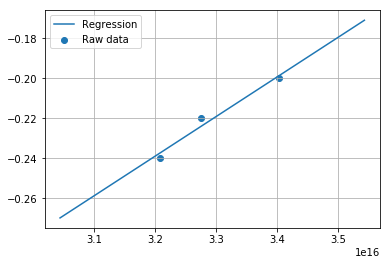

In [304]:
x, y = df_V_lambda['omega'], df_V_lambda['V_0']
# plt.scatter(x, y)
# TODO: разберись с точками
# Там плохие точки. Я их выкину пока
plt.scatter(x[1:4], y[1:4], label=r'Raw data')
from scipy.stats import linregress
h_slope, h_intercept, r_value, p_value, std_err = linregress(x[1:4], y[1:4])
x_linreg = np.linspace(min(x), max(x), 1000)
plt.plot(x_linreg, h_slope*x_linreg + h_intercept, label=r'Regression')


plt.legend()
plt.grid()
plt.show()

In [306]:
print('k = {}'.format(h_slope))

k = 1.9812242337871145e-17


Исходя из углового коэффициента имеем $\hbar$:

In [308]:
hbar = h_slope * 1.6*10**(-19)
h = 2*np.pi*hbar

In [310]:
h

1.991743839353493e-35